In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../2330.TW_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-03,103.0,103.0,102.0,102.5,75.244667,38599000
2014-01-06,102.0,103.0,102.0,102.5,75.244667,23706000
2014-01-07,102.5,103.0,102.0,102.0,74.877609,15836000
2014-01-08,103.0,104.5,102.5,104.0,76.345802,30218000
2014-01-09,102.5,103.0,100.5,101.0,74.143509,63998000
...,...,...,...,...,...,...
2023-12-25,582.0,585.0,580.0,581.0,573.515503,9548143
2023-12-26,583.0,586.0,582.0,586.0,578.451111,16094308
2023-12-27,587.0,592.0,586.0,592.0,584.373840,33401336


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
X_train.shape[2]

(2439, 4)
torch.Size([1931, 10, 4])


4

In [4]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # 建立一個位置編碼矩陣
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數位置
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x 的形狀為 (seq_length, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return x

In [5]:
class TransformerTimeSeriesAutoregressive(nn.Module):
    def __init__(self, feature_size, num_layers=2, nhead=4, hidden_dim=128, lstm_hidden_dim=128, dropout=0.1):
        super(TransformerTimeSeriesAutoregressive, self).__init__()
        self.model_type = 'Autoregressive Transformer with BiLSTM Decoder and Teacher Forcing'

        self.input_linear = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Linear projection for h_0 and c_0
        self.h0_projection = nn.Linear(hidden_dim, lstm_hidden_dim)
        self.c0_projection = nn.Linear(hidden_dim, lstm_hidden_dim)

        # Change LSTM to BiLSTM
        self.lstm_decoder = nn.LSTM(input_size=hidden_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=False, bidirectional=True)
        self.output_linear = nn.Linear(lstm_hidden_dim, feature_size)

        self.residual_projection = nn.Linear(feature_size, hidden_dim) if feature_size != hidden_dim else None
        self.hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim

    def forward(self, src, target=None, teacher_forcing_ratio=0.5):
        batch_size, seq_length, feature_size = src.size()
        pred_length = target.size(1) if target is not None else 10

        if self.residual_projection:
            residual_src = self.residual_projection(src)
        else:
            residual_src = src
        
        residual_src = residual_src.permute(1, 0, 2)
        src = src.permute(1, 0, 2)
        src = self.input_linear(src)
        src = self.pos_encoder(src)

        transformer_output = self.transformer_encoder(src)
        transformer_output = transformer_output + residual_src

        # Use the last timestep's output to initialize h_0 and c_0
        last_step_output = transformer_output[-1]  # (batch_size, hidden_dim)
        h_0 = self.h0_projection(last_step_output).unsqueeze(0)  # (1, batch_size, lstm_hidden_dim)
        c_0 = self.c0_projection(last_step_output).unsqueeze(0)  # (1, batch_size, lstm_hidden_dim)

        # Adjust for BiLSTM (repeat for two directions)
        h_0 = h_0.repeat(2, 1, 1)  # (2, batch_size, lstm_hidden_dim)
        c_0 = c_0.repeat(2, 1, 1)  # (2, batch_size, lstm_hidden_dim)

        # Start autoregressive decoding
        decoder_input = transformer_output[-1, :, :].unsqueeze(0)  # (1, batch_size, hidden_dim)
        outputs = []

        for t in range(pred_length):
            lstm_output, (h_0, c_0) = self.lstm_decoder(decoder_input, (h_0, c_0))
            
            # Merge BiLSTM outputs (sum forward and backward outputs)
            lstm_output = lstm_output[:, :, :self.lstm_hidden_dim] + lstm_output[:, :, self.lstm_hidden_dim:]
            lstm_output = lstm_output + decoder_input  # Residual connection

            output = self.output_linear(lstm_output.squeeze(0))
            outputs.append(output.unsqueeze(1))

            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = self.input_linear(target[:, t, :]).unsqueeze(0)
            else:
                decoder_input = self.input_linear(output).unsqueeze(0)

        outputs = torch.cat(outputs, dim=1)
        return outputs


In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 1e-4

feature_size = 4  # 輸入特徵數
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeriesAutoregressive(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [12]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "trans_bilstm_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
        x_batch= x_batch.to(device)
        # print(x_batch.shape)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.5).squeeze(-1)
        # print(outputs.shape)
        # print(y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.0).squeeze(-1)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path)  
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.0173, Val Loss: 0.0583
Epoch [2/100], Train Loss: 0.0943, Val Loss: 0.0164
Epoch [3/100], Train Loss: 0.0360, Val Loss: 0.0113
Epoch [4/100], Train Loss: 0.0045, Val Loss: 0.0023
Epoch [5/100], Train Loss: 0.0020, Val Loss: 0.0013
Epoch [6/100], Train Loss: 0.0016, Val Loss: 0.0011
Epoch [7/100], Train Loss: 0.0014, Val Loss: 0.0008
Epoch [8/100], Train Loss: 0.0014, Val Loss: 0.0007
Epoch [9/100], Train Loss: 0.0013, Val Loss: 0.0008
Epoch [10/100], Train Loss: 0.0013, Val Loss: 0.0008
Epoch [11/100], Train Loss: 0.0013, Val Loss: 0.0007
Epoch [12/100], Train Loss: 0.0012, Val Loss: 0.0010
Epoch [13/100], Train Loss: 0.0015, Val Loss: 0.0012
Epoch [14/100], Train Loss: 0.0020, Val Loss: 0.0045
Epoch [15/100], Train Loss: 0.0029, Val Loss: 0.0082
Epoch [16/100], Train Loss: 0.0056, Val Loss: 0.0163
Epoch [17/100], Train Loss: 0.0115, Val Loss: 0.0273
Epoch [18/100], Train Loss: 0.0072, Val Loss: 0.1577
Epoch [19/100], Train Loss: 0.0066, Val Loss: 0.0264
Ep

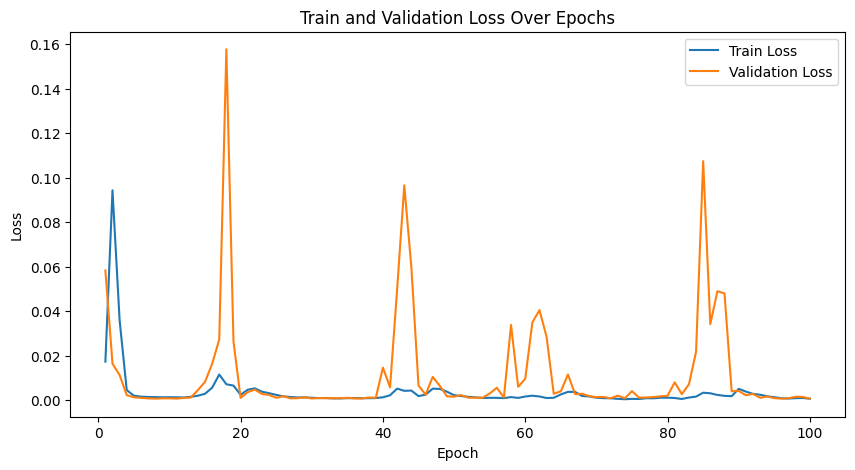

In [13]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

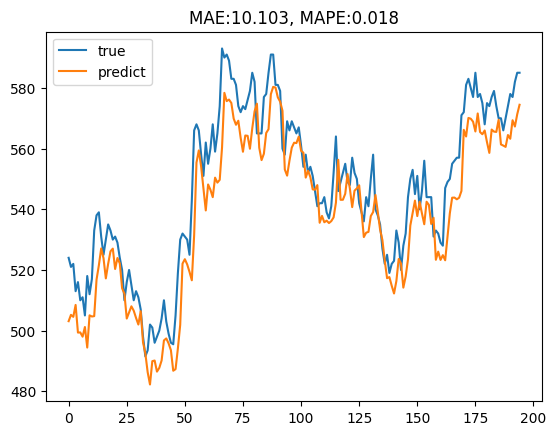

In [14]:
import matplotlib.pyplot as plt
close_price_true = []
close_price_pred = []
model = torch.load('trans_bilstm_10.pth')
model.to(device)

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0).squeeze(-1)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])

In [15]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
print("mape: ", mape)
print("mae: ", mae)

(195, 10)
(195, 10)
mape:  0.024179939070531165
mae:  13.252506172198515


In [9]:
ma10_f=[]
true=[]
pred=[]
for i in range(0,len(close_price_pred)):
    true.append(round(close_price_true[i][0]))
    ma10_f.append(np.mean(close_price_pred[i]))
    pred.append(close_price_pred[i][0])

newdf = pd.DataFrame({'True':true, 'Pred':pred, 'MA10_F':ma10_f})
newdf

,True,Pred,MA10_F
0,524,499.620966,500.083634
1,521,501.635681,502.133291
2,522,500.405214,500.902862
3,513,503.401351,503.886532
4,516,495.369364,495.884771
...,...,...,...
190,578,558.349660,558.886635
191,577,562.679555,563.183331
192,582,561.423014,561.882928
193,585,564.329123,564.934266


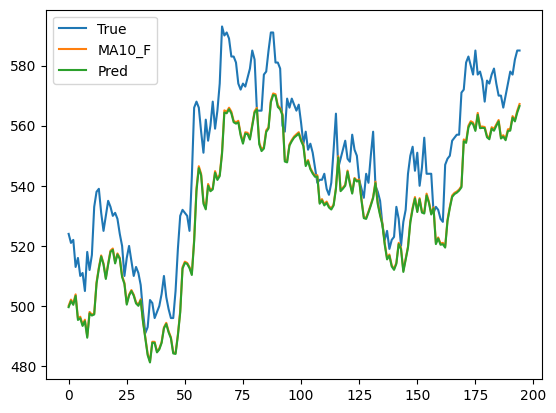

In [10]:
plt.plot(newdf['True'])
plt.plot(newdf['MA10_F'])
plt.plot(newdf['Pred'])
plt.legend(['True','MA10_F','Pred'])

In [11]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, ma10_f, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (ma10_f[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (ma10_f[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['MA10_F'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 1000000 0
5 1000000 0
6 1000000 0
7 1000000 0
8 1000000 0
9 1000000 0
10 1000000 0
11 1000000 0
12 1000000 0
13 1000000 0
14 1000000 0
15 1000000 0
16 1000000 0
17 1000000 0
18 1000000 0
19 1000000 0
20 1000000 0
21 1000000 0
22 1000000 0
23 1000000 0
24 1000000 0
25 1000000 0
26 1000000 0
27 1000000 0
28 1000000 0
29 1000000 0
30 1000000 0
31 1000000 0
32 1000000 0
33 1000000 0
34 1000000 0
35 1000000 0
36 1000000 0
37 1000000 0
38 1000000 0
39 1000000 0
40 1000000 0
41 1000000 0
42 1000000 0
43 1000000 0
44 1000000 0
45 1000000 0
46 1000000 0
47 1000000 0
48 1000000 0
49 1000000 0
50 1000000 0
51 1000000 0
52 1000000 0
53 1000000 0
54 1000000 0
55 1000000 0
56 1000000 0
57 1000000 0
58 1000000 0
59 1000000 0
60 1000000 0
61 1000000 0
62 1000000 0
63 1000000 0
64 1000000 0
65 1000000 0
66 1000000 0
67 1000000 0
68 1000000 0
69 1000000 0
70 1000000 0
71 1000000 0
72 1000000 0
73 1000000 0
74 1000000 0
75 1000000 0
76 1000000 0
77 1000000 0
78 10000

In [12]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, pred, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (pred[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (pred[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['Pred'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 1000000 0
5 1000000 0
6 1000000 0
7 1000000 0
8 1000000 0
9 1000000 0
10 1000000 0
11 1000000 0
12 1000000 0
13 1000000 0
14 1000000 0
15 1000000 0
16 1000000 0
17 1000000 0
18 1000000 0
19 1000000 0
20 1000000 0
21 1000000 0
22 1000000 0
23 1000000 0
24 1000000 0
25 1000000 0
26 1000000 0
27 1000000 0
28 1000000 0
29 1000000 0
30 1000000 0
31 1000000 0
32 1000000 0
33 1000000 0
34 1000000 0
35 1000000 0
36 1000000 0
37 1000000 0
38 1000000 0
39 1000000 0
40 1000000 0
41 1000000 0
42 1000000 0
43 1000000 0
44 1000000 0
45 1000000 0
46 1000000 0
47 1000000 0
48 1000000 0
49 1000000 0
50 1000000 0
51 1000000 0
52 1000000 0
53 1000000 0
54 1000000 0
55 1000000 0
56 1000000 0
57 1000000 0
58 1000000 0
59 1000000 0
60 1000000 0
61 1000000 0
62 1000000 0
63 1000000 0
64 1000000 0
65 1000000 0
66 1000000 0
67 1000000 0
68 1000000 0
69 1000000 0
70 1000000 0
71 1000000 0
72 1000000 0
73 1000000 0
74 1000000 0
75 1000000 0
76 1000000 0
77 1000000 0
78 10000

In [17]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x, y = test_set[i]
    x = torch.unsqueeze(x, 0)
    y = torch.unsqueeze(y, 0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    
    # 取第十天的真實值和預測值
    y_tenth_day = torch.squeeze(y)[9]  # 第 10 天對應索引為 9
    pred_tenth_day = torch.squeeze(pred.detach().cpu())[9]
    
    # 反轉換
    true_tenth_day = scaler.inverse_transform(y_tenth_day.unsqueeze(0))[:, dim]
    pred_tenth_day = scaler.inverse_transform(pred_tenth_day.unsqueeze(0))[:, dim]
    
    # 儲存第十天的值
    close_price_true.append(true_tenth_day)
    close_price_pred.append(pred_tenth_day)

# 將結果轉換為 NumPy 陣列
close_price_true = np.array(close_price_true).squeeze()
close_price_pred = np.array(close_price_pred).squeeze()

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)

# 計算 MAE 和 MAPE
mape = np.mean(np.abs(close_price_true - close_price_pred) / close_price_true)
mae = np.mean(np.abs(close_price_true - close_price_pred))

print("第十天的 mape: ", mape)
print("第十天的 mae: ", mae)

(195,)
(195,)
第十天的 mape:  0.03111334614577161
第十天的 mae:  17.009021561115215


In [18]:
import csv

with open('ex2output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i][0].item())

# 寫回檔案
with open('ex2output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

FileNotFoundError: [Errno 2] No such file or directory: 'ex2output.csv'